# Potential Talents - An Apziva Project (#3)

# Proceed to the [previous notebook](potential_talents_p1.ipynb) to view the EDA and initial NLP work.

# Modeling

By Samuel Alter

Apziva: 6bImatZVlK6DnbEo

## Project Overview

We are working with a talent sourcing and management company to help them surface candidates that are a best fit for their human resources job post. We are using a dataset of job candidates' job titles, their location, and their number of LinkedIn connections.

### Goals

Produce a probability, between 0 and 1, of how closely the candidate fits the job description of **"Aspiring human resources"** or **"Seeking human resources."** After an initial recommendation pulls out a candidate(s) to be starred for future consideration, the recommendation will be re-run and new "stars" will be awarded.

To help predict how the candidates fit, we are tracking the performance of two success metrics:
* Rank candidates based on a fitness score
* Re-rank candidates when a candidate is starred

We also need to do the following:
* Explain how the algorithm works and how the ranking improves after each starring iteration
* How to filter out candidates which should not be considered at all
* Determine a cut-off point (if possible) that would work for other roles without losing high-potential candidates
* Ideas to explore on automating this procedure to reduce or eliminate human bias

### The Dataset

| Column | Data Type | Comments |
|---|---|---|
| `id` | Numeric | Unique identifier for the candidate |
| `job_title` | Text | Job title for the candidate |
| `location` | Text | Geographic location of the candidate |
| `connections` | Text | Number of LinkedIn connections for the candidate |

Connections over 500 are encoded as "500+". Some do not have specific locations listed and just had their country, so I substituted capitol cities or geographic centers to represent those countries.

# Imports and Helper Functions

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib
from torchview import draw_graph
import torch.nn.functional as F
from collections import defaultdict

In [2]:
# simple function to generate random integers

def rand_gen(low=1,high=1e4):
    '''
    Generates a pseudo-random integer
    consisting of up to four digits
    '''
    import numpy as np
    rng=np.random.default_rng()
    random_state=int(rng.integers(low=low,high=high))
    
    return random_state

In [3]:
seed=rand_gen()
seed

7909

In [4]:
# set the randomness seed throughout the notebook
# source: # https://odsc.medium.com/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752

## set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed)
## set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed)
## set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed)
np.random.default_rng(seed)

Generator(PCG64) at 0x12B30C820

In [5]:
def get_variable_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [name for name, val in callers_local_vars if val is var]

def fileDaterSaver(location: str,
                   filetype: str,
                   object_,
                   extra: str = '',
                   verbose: bool = True):

    '''
    Function that gets a timestamped filename and saves it
    to a user-specified location.

    Parameters:
    -----------
    location: str - The location where the file will be saved.
    filetype: str - The type of the file to save ('csv' or 'json').
    object_: The object to be saved. Should be a pandas DataFrame
        for 'csv' or serializable for 'json'.
    extra: str - Additional string to include in the filename.
    verbose: bool - Whether to print verbose messages.
    '''

    # get current date and time
    current_datetime = datetime.now()

    # print current date and time to check
    if verbose:
        print('current_datetime:', current_datetime)

    # format the datetime for a filename
    datetime_suffix = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

    # create filename with the datetime suffix
    if extra != '':
        file_name = f'{location}{extra}_{datetime_suffix}.{filetype}'
    else:
        file_name = f'{location}{datetime_suffix}.{filetype}'

    # print file name
    if verbose:
        print(file_name)

    # save object
    if filetype == 'csv':
        object_.to_csv(file_name, index=True)
    elif filetype == 'json':
        with open(file_name, 'w') as file:
            file.write(json.dumps(object_, default=str))
    else:
        raise ValueError("Unsupported file type. Use 'csv' or 'json'.")

    # confirm save
    file_path = Path(file_name)
    if file_path.exists():
        variable_name = get_variable_name(object_)
        if variable_name:
            print(f'Successfully saved {variable_name[0]} to {file_path}')
        else:
            print(f'Successfully saved object to {file_path}')
    else:
        print("File save error.")

Saving Models

A common way to save a model is to serialize the internal state dictionary (containing the model parameters).

In [13]:
path=Path("../joblib/3_testmodel.pth")
torch.save(model.state_dict(), path)
print(f"Saved PyTorch Model State to {path}")

Saved PyTorch Model State to ../joblib/3_testmodel.pth


Loading Models

The process for loading a model includes re-creating the model structure and loading the state dictionary into it.

In [14]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load(path, weights_only=True))

<All keys matched successfully>

This model can now be used to make predictions.

In [15]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


# Learning to Rank (LTR) systems 

[RankNet](https://icml.cc/Conferences/2015/wp-content/uploads/2015/06/icml_ranking.pdf) is an influential algorithm that is designed to rank items given an objective. LTR systems are used for information retrieval, which is crucial for search engines, recommender systems like on Netflix or Amazon, travel agencies, and online advertising.

You can learn more about LTR systems from [this](https://towardsdatascience.com/learning-to-rank-a-complete-guide-to-ranking-using-machine-learning-4c9688d370d4) Medium post by [Francesco Casalegno](https://medium.com/@francesco.casalegno).

RankNet uses a "pairwise" method of training, meaning it predices which item in a pair should be ranked higher based on a probabilistic model. With pairs of items, using RankNet makes our task a binary classification problem.

Epoch 0, Loss: 0.6969847083091736
Epoch 250, Loss: 0.613135576248169
Epoch 500, Loss: 0.5883915424346924
Epoch 750, Loss: 0.5799568891525269


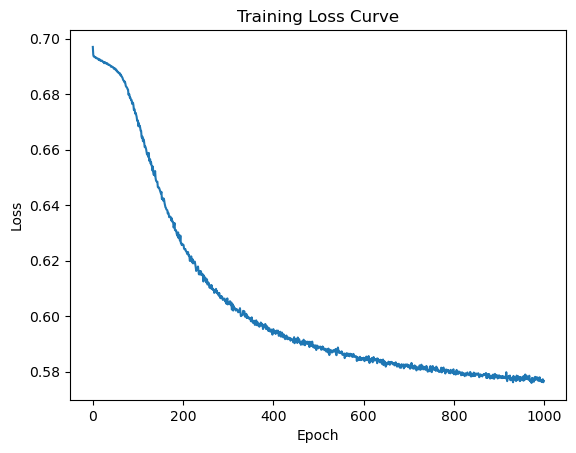

## RankNet NN

#### `device` Setup

In [239]:
# get cpu, gpu or mps device for training.
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using mps device


#### `RankNet` class

RankNet, a pairwise ranking algorithm, is differentiated in its ranking methodology rather than the specifics of its architecture. It is defined by:
* **Pairwise comparison** of pairs of inputs
* **Sigmoid-based** probability output
* **Loss function** involving **Binary Cross-Entropy Loss** to compute error between predicted probabilities and true pairwise labels
* **Backpropagation and gradient decent** allows for training and updating weights using gradients calculated from the pairwise ranking loss

The architecture is not fixed and we can:
* Add or remove layers
* Change the number of neurons in the hidden layers
* Adjust activation functions
* Change dropout rates

In [240]:
class RankNet(nn.Module):
    def __init__(self, n_feature):
        super(RankNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_feature, 512),
            nn.BatchNorm1d(512), # normalization
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256), # another round of normalization
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1)
        )
        
    def forward(self, input_1, input_2):
        # define inputs and handle potentail length issue
        input_1 = input_1.to(device).float().unsqueeze(0) if len(input_1.shape) == 1 else input_1
        input_2 = input_2.to(device).float().unsqueeze(0) if len(input_2.shape) == 1 else input_2
        s1 = self.model(input_1)
        s2 = self.model(input_2)
        return s1 - s2

#### Load training and testing data

Now that we have the neural network defined, we need to load the training files saved as parquet from the end of Part 1 of the project.

In [241]:
# load data
train_data = pd.read_parquet('../joblib/3_pairs_train.parquet', engine='pyarrow')
test_data = pd.read_parquet('../joblib/3_pairs_test.parquet', engine='pyarrow')

In [242]:
# load data from parquet files
train_input_1 = torch.tensor(train_data['input_1'].tolist(), dtype=torch.float32)
train_input_2 = torch.tensor(train_data['input_2'].tolist(), dtype=torch.float32)
train_labels = torch.tensor(train_data['label'].tolist(), dtype=torch.float32)

# preserve IDs for later use (but exclude them from model input)
train_ids_1 = train_data['id_1'].tolist()
train_ids_2 = train_data['id_2'].tolist()

test_input_1 = torch.tensor(test_data['input_1'].tolist(), dtype=torch.float32)
test_input_2 = torch.tensor(test_data['input_2'].tolist(), dtype=torch.float32)
test_labels = torch.tensor(test_data['label'].tolist(), dtype=torch.float32)

test_ids_1 = test_data['id_1'].tolist()
test_ids_2 = test_data['id_2'].tolist()

# create TensorDataset without IDs (they're stored separately)
train_dataset = TensorDataset(train_input_1, train_input_2, train_labels)
test_dataset = TensorDataset(test_input_1, test_input_2, test_labels)

# create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### Training loop

##### Hyperparameter definitions

In [243]:
# retrieve shape of tensors from file produced in Part 1
with open('../joblib/3_n_feature.txt', 'r') as file:
    num_features = int(file.read())
    print('num_features:',num_features)

n_feature = num_features
learning_rate = 0.01
batch_size = 64
epochs = 25

num_features: 384


##### Instantiate model and define loss function and optimizer

In [244]:
def train(model, train_loader, loss_fn, optimizer, device, epochs=50):
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        epoch_loss = 0
        correct_predictions = 0
        total_samples = 0

        for batch in train_loader:
            input_1, input_2, labels = batch
            input_1, input_2, labels = input_1.to(device), input_2.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(input_1, input_2).squeeze()

            # Calculate loss
            loss = loss_fn(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Track loss
            epoch_loss += loss.item()

            # Calculate accuracy (threshold 0.5 for binary classification)
            predicted = torch.sigmoid(outputs) > 0.5
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        epoch_accuracy = correct_predictions / total_samples
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss / len(train_loader):.4f}, Accuracy: {epoch_accuracy:.4f}")

In [245]:
rank_net = RankNet(n_feature=n_feature).to(device)
loss_fn = nn.BCEWithLogitsLoss() # binary cross-entropy loss with logits
optimizer = torch.optim.Adam(rank_net.parameters(), lr=learning_rate)
print(rank_net)

RankNet(
  (model): Sequential(
    (0): Linear(in_features=384, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [246]:
# visualize RankNet
from torchviz import make_dot

# create a dummy input tensor to visualize the model (example: 1 sample with 'n_feature' features)
dumy_input = torch.randn(1, n_feature).to(device)

# generate the graph (make_dot creates a directed graph from the model)
rank_net.eval()  # Put model in evaluation mode
output = rank_net(dummy_input, dummy_input)  # Using dummy input for both inputs in RankNet

# create the dot graph (this is a visualization of the model's architecture)
dot = make_dot(output, params=dict(rank_net.named_parameters()))

# render and display the graph
dot.render('figures/3_ranknet_architecture', format='png', view=True)  # saves and views the plot

'figures/3_ranknet_architecture.png'

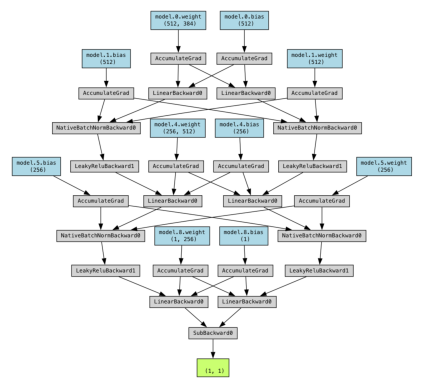

In [247]:
# view architecture
import matplotlib.image as mpimg
img = mpimg.imread('figures/3_ranknet_architecture.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

In [248]:
train(rank_net, train_loader, loss_fn, optimizer, device, epochs)

Epoch [1/25], Loss: 0.7135, Accuracy: 0.5903
Epoch [2/25], Loss: 0.6437, Accuracy: 0.6291
Epoch [3/25], Loss: 0.6354, Accuracy: 0.6410
Epoch [4/25], Loss: 0.6023, Accuracy: 0.6692
Epoch [5/25], Loss: 0.5895, Accuracy: 0.6723
Epoch [6/25], Loss: 0.5830, Accuracy: 0.6837
Epoch [7/25], Loss: 0.5797, Accuracy: 0.6828
Epoch [8/25], Loss: 0.5645, Accuracy: 0.6921
Epoch [9/25], Loss: 0.5638, Accuracy: 0.6907
Epoch [10/25], Loss: 0.5579, Accuracy: 0.6944
Epoch [11/25], Loss: 0.5560, Accuracy: 0.6933
Epoch [12/25], Loss: 0.5572, Accuracy: 0.6874
Epoch [13/25], Loss: 0.5504, Accuracy: 0.7021
Epoch [14/25], Loss: 0.5443, Accuracy: 0.6991
Epoch [15/25], Loss: 0.5430, Accuracy: 0.6998
Epoch [16/25], Loss: 0.5490, Accuracy: 0.6891
Epoch [17/25], Loss: 0.5451, Accuracy: 0.6954
Epoch [18/25], Loss: 0.5372, Accuracy: 0.7054
Epoch [19/25], Loss: 0.5407, Accuracy: 0.6968
Epoch [20/25], Loss: 0.5397, Accuracy: 0.7059
Epoch [21/25], Loss: 0.5435, Accuracy: 0.6979
Epoch [22/25], Loss: 0.5379, Accuracy: 0.71

#### Evaluate model and match IDs with predictions

In [249]:
def test(model, test_loader, loss_fn, device, test_ids_1, test_ids_2, batch_size):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct_predictions = 0
    total_samples = 0

    predictions = []
    id_pairs = []  # Store the associated IDs for each prediction

    with torch.no_grad():
        for idx, batch in enumerate(test_loader):
            input_1, input_2, labels = batch
            input_1, input_2, labels = input_1.to(device), input_2.to(device), labels.to(device)

            # Forward pass
            outputs = model(input_1, input_2).squeeze()

            # Calculate loss
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()

            # Calculate accuracy
            predicted = torch.sigmoid(outputs) > 0.5
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            # Store predictions and IDs
            predicted_probs = torch.sigmoid(outputs).cpu().numpy()
            predictions.extend(predicted_probs)

            # Track the associated ID pairs for each batch
            id_pairs.extend(zip(test_ids_1[idx * batch_size:(idx + 1) * batch_size],
                                test_ids_2[idx * batch_size:(idx + 1) * batch_size]))

    # Calculate final metrics
    test_accuracy = correct_predictions / total_samples
    avg_test_loss = test_loss / len(test_loader)
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Match predictions to IDs
    results = pd.DataFrame({
        'id_1': [pair[0] for pair in id_pairs],
        'id_2': [pair[1] for pair in id_pairs],
        'predicted_prob': predictions,
    })

    return results

In [250]:
results = test(rank_net, test_loader, loss_fn, device, test_ids_1, test_ids_2, batch_size)
print(results.head())  # display the first few results

Test Loss: 0.6503, Test Accuracy: 0.6166
   id_1  id_2  predicted_prob
0    73   101        0.484841
1    33    57        0.579996
2    47   100        0.652011
3    20    75        0.880610
4    27    32        0.678263


#### Track which candidates "won" more

In [251]:
# initialize a dictionary to count the number of "wins" for each candidate
rank_scores = defaultdict(int)

# aggregate results: count how often each ID is ranked higher
for _, row in results.iterrows():
    id_1, id_2, predicted_prob = row['id_1'], row['id_2'], row['predicted_prob']
    
    # if predicted probability is greater than 0.5, id_1 is ranked higher
    if predicted_prob > 0.5:
        rank_scores[id_1] += 1
    else:
        rank_scores[id_2] += 1

# sort candidates by their score (higher is better)
final_ranking = sorted(rank_scores.items(), key=lambda x: x[1], reverse=True)

# print top 10 rows
# for rank, (candidate_id, score) in enumerate(final_ranking[:10], 1):
#     print(f"Rank {rank}: Candidate ID {int(candidate_id)} with score {score}")

final_ranking_df = pd.DataFrame(data=final_ranking, columns=['id','score'])
final_ranking_df['id'] = pd.to_numeric(final_ranking_df['id'],
                                      downcast='integer', errors='coerce').astype(str)
final_ranking_df.head(10)

,id,score
0,92,28
1,82,24
2,32,22
3,33,21
4,85,21
5,27,20
6,49,20
7,28,20
8,46,20
9,58,20


##### Plot results

In [252]:
# read in original data
df = pd.read_csv('../data/3_data.csv')
df['id'] = df['id'].astype(str)
final_ranking_df['id'] = final_ranking_df['id'].astype(str)

# add job_titles to final_ranking_df to match the IDs
final_ranking_merged = pd.merge(final_ranking_df, df[['id','job_title']], on='id', how='left')
final_ranking_merged.head()

,id,score,job_title
0,92,28,Seeking employment opportunities within Custom...
1,82,24,Aspiring Human Resources Professional | An ene...
2,32,22,Native English Teacher at EPIK (English Progra...
3,33,21,Aspiring Human Resources Professional
4,85,21,RRP Brand Portfolio Executive at JTI (Japan To...


In [253]:
# check to make sure it worked - this job title should match above
first_row = final_ranking_merged[:1]['id'][0] # get id
df[['id','job_title']][df['id']==first_row]

,id,job_title
91,92,Seeking employment opportunities within Custom...


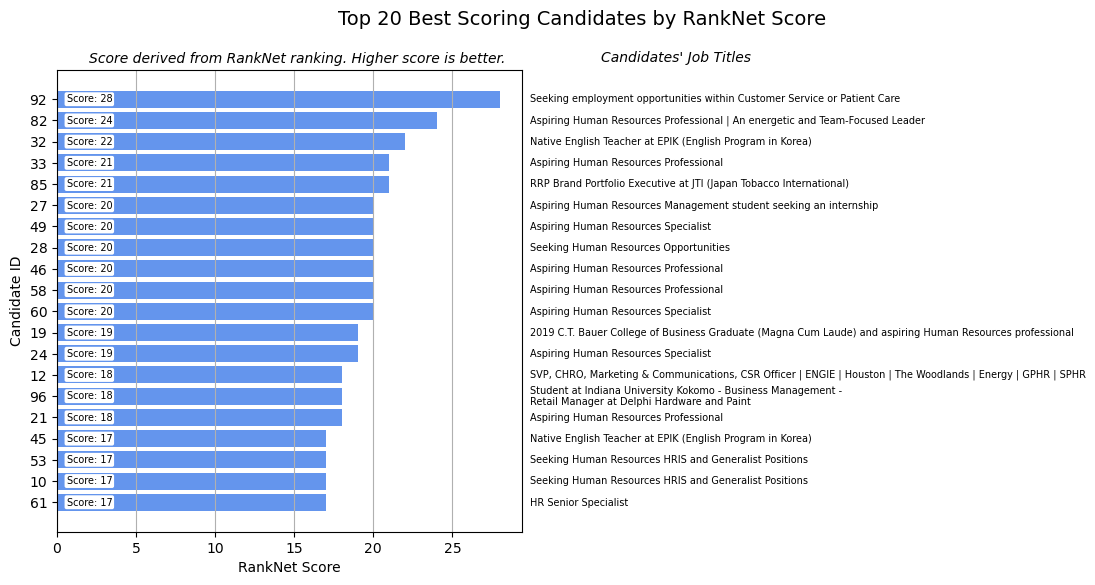

In [254]:
cutoff = 20

# Plot the horizontal bar chart
fig, ax = plt.subplots(figsize=(6, 6))
plt.gca().invert_yaxis()
plt.barh(y=final_ranking_merged[:cutoff]['id'], 
         width=final_ranking_merged[:cutoff]['score'], 
         color='cornflowerblue')

xmax = ax.get_xlim()[1]
xmin = ax.get_xlim()[0]
ymax = ax.get_ylim()[1]
ymin = ax.get_ylim()[0]

# Add labels with scores from specified columns on the bars
for index, row in final_ranking_merged[:cutoff].iterrows():
    # Format the text to display the scores for each bar
    label = (
        f"Score: {row['score']:.0f}"
    )
    plt.text(
        0.6, # distance from y-axis
        row['id'], 
        label,
        ha='left',
        va='center',
        fontsize=7,
        color='black', # text color
        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2') # White background
    )

    # add the job_title to each corresponding applicant
    plt.text(
        xmax + 0.5,
        row['id'],
        f"{row['job_title']}",
        ha='left',
        va='center',
        fontsize=7,
        color='black'
    )
    
# Add labels and title for clarity
plt.ylabel('Candidate ID')
plt.xlabel('RankNet Score')
plt.suptitle(f'Top {cutoff} Best Scoring Candidates by RankNet Score', fontsize=14, x=1)

# add subtitle
axes=plt.gca()
ylim=axes.get_ylim()
plt.text(x=2, y=ymax-0.5, # position just above highest y-limit, note that axes are inverted
         s='Score derived from RankNet ranking. Higher score is better.', fontsize=10, style='italic', ha='left', va='center')
plt.text(x=xmax+5, y=ymax-0.4,
         s="Candidates' Job Titles", fontsize=10, style='italic')
plt.grid(axis='x')

plt.savefig('figures/3_ranknet_results.pdf',bbox_inches='tight')
plt.savefig('figures/3_ranknet_results.jpg',bbox_inches='tight')
plt.savefig('figures/3_ranknet_results.png',bbox_inches='tight')

plt.show()

In [255]:
# confirm the plot shows what we expect
df[df['id']=='92']

,id,job_title,location,connection,fit
91,92,Seeking employment opportunities within Custom...,"Torrance, California",64,NaN


In [258]:
# save model
path=Path("../joblib/3_ranknet_trained.pth")
torch.save(rank_net.state_dict(), path)
print(f"Saved PyTorch Model State to {path}")

# load model
rank_net = RankNet(n_feature=n_feature).to(device)
rank_net.load_state_dict(torch.load(path, weights_only=True))

Saved PyTorch Model State to ../joblib/3_ranknet_trained.pth


RuntimeError: Error(s) in loading state_dict for RankNet:
	Missing key(s) in state_dict: "model.0.weight", "model.0.bias", "model.1.weight", "model.1.bias", "model.1.running_mean", "model.1.running_var", "model.4.weight", "model.4.bias", "model.5.weight", "model.5.bias", "model.5.running_mean", "model.5.running_var", "model.8.weight", "model.8.bias". 
	Unexpected key(s) in state_dict: "linear_relu_stack.0.weight", "linear_relu_stack.0.bias", "linear_relu_stack.2.weight", "linear_relu_stack.2.bias", "linear_relu_stack.4.weight", "linear_relu_stack.4.bias". 